In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import sklearn
import random
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
filename = 'Dataset/Sensor_Discrimination_normalized.csv'
df=pd.read_csv(filename)
# shuffle the DataFrame rows
df = df.sample(frac = 1) #frac = fraction
dataset=df.iloc[:,:-1]
label=df.iloc[:,-1]
print(dataset)
print(label)

            F2        F3        F1       F11        F4        F6       F10  \
1401  0.199230  0.914536  0.889128  0.986879  0.994512  0.768279  0.963102   
2086  0.139957  0.885935  0.846229  0.239362  0.899551  0.549203  0.342244   
438   0.707380  0.798957  0.594123  0.243794  0.716281  0.103024  0.258848   
838   0.474439  0.854812  0.597258  0.213652  0.706137  0.219791  0.324172   
2154  0.147529  0.926144  0.818022  0.299113  0.843339  0.481034  0.705572   
...        ...       ...       ...       ...       ...       ...       ...   
561   0.319572  0.821332  0.607640  0.187234  0.592217  0.237218  0.203878   
1566  0.395936  0.915377  0.919099  0.990426  0.980875  0.802639  0.953690   
938   0.210460  0.945491  0.888737  0.338475  0.978879  0.744365  0.962161   
1867  0.111765  0.893674  0.892654  0.282624  0.892899  0.565970  0.538968   
1580  0.382888  0.948015  0.942997  0.950177  0.973391  0.883727  0.943712   

            F9        F5      F7     F12       F8  
1401  0.866

# PCA Implementation

In [3]:
pcaTrain = PCA(n_components=3).fit(dataset)# --train-- pca with the "dataset" Dataframe
print(pcaTrain)
compressed_dataset_X= pcaTrain.transform(dataset) # --transform-- the original "dataset" Dataframe into a lower-dimensional space based on the model's learned parameters
print(type(compressed_dataset_X))
print(len(compressed_dataset_X[0]))
print(compressed_dataset_X)

PCA(n_components=3)
<class 'numpy.ndarray'>
3
[[ 1.45421598  1.34307358 -0.03004047]
 [-3.1111973  -0.13776672 -0.30033712]
 [ 1.42701686 -0.57247571  0.12773435]
 ...
 [-3.30710053  1.10319571  0.18895804]
 [-2.95506556 -0.02577435 -0.3807193 ]
 [ 1.20329385  1.24825328 -0.07262644]]


In [4]:
dataset_arr=dataset.to_numpy()
# from NecessaryModules.splitData import split_data
X_train, X_test, y_train, y_test = train_test_split(dataset_arr, label, test_size=0.3, random_state=42)
print(len(X_train))

1548


In [5]:
compressed_dataset_X_train= pcaTrain.transform(X_train) # --transform-- the original "dataset" Dataframe into a lower-dimensional space based on the model's learned parameters
print(type(compressed_dataset_X_train))
print(len(compressed_dataset_X_train))
print(compressed_dataset_X_train)

compressed_dataset_X_test= pcaTrain.transform(X_test) # --transform-- the original "dataset" Dataframe into a lower-dimensional space based on the model's learned parameters
print(type(compressed_dataset_X_test))
print(len(compressed_dataset_X_test))
print(compressed_dataset_X_test)

<class 'numpy.ndarray'>
1548
[[ 0.79787968  0.10567558 -0.26288094]
 [ 1.46491499 -0.04827686 -0.32408259]
 [ 1.16170333 -0.03599388 -0.42028633]
 ...
 [-3.8891226  -0.96697292  0.03155412]
 [-3.30413732  0.24769121 -0.37580057]
 [ 1.29256783 -0.31392431 -0.22087216]]
<class 'numpy.ndarray'>
664
[[ 1.87406831 -0.34597403  0.07056039]
 [ 1.51151269  1.09148911 -0.17025694]
 [ 1.50763058 -0.86837243  0.35547658]
 ...
 [ 0.90896836 -0.92070416  0.14052036]
 [-3.08023033 -0.08154662 -0.32685357]
 [ 1.05683389  0.29250757 -0.1157147 ]]


# tune SVC

In [6]:
# train the model with random parameter
from sklearn.svm import SVC

model_SVC = SVC(
        C=8.75,#Regularization parameter
        kernel="rbf", # maximum number of estimators at which boosting is terminated
        gamma=0.4,
        tol=0.483,
        decision_function_shape='ovo',
        
     )

model_SVC.fit(compressed_dataset_X_train, y_train)

SVC(C=8.75, decision_function_shape='ovo', gamma=0.4, tol=0.483)

In [7]:
# Finding mean absolute error
preds = model_SVC.predict(compressed_dataset_X_test)
preds = preds.astype(int)
mae = np.abs(y_test-preds).mean()
mae

0.07981927710843373

In [8]:
# Defining the best parameter with optuna
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import StratifiedKFold
K = 5 # stratified 5 fold cross validation, The folds are made by preserving the percentage of samples for each class.
skf = StratifiedKFold(n_splits = K, random_state = 42, shuffle = True)

train_tunned= np.array(compressed_dataset_X)
target_train_tunned= np.array(label)

oof_preds= np.zeros((len(train_tunned)))
abs_error_arr=[]
def objective_SVC(trial):

 for train_index, val_index in (skf.split(compressed_dataset_X,label)):
    train_X, valid_X = train_tunned[train_index], train_tunned[val_index]
    train_Y, valid_Y = target_train_tunned[train_index], target_train_tunned[val_index]
    
        
        
    param = {
        'C':trial.suggest_float("C",0,10), #For regularization    
        'kernel':trial.suggest_categorical('kernel',["linear", "poly", "rbf", "sigmoid"]),
        'degree':trial.suggest_int('degree',1,10),
        'gamma':trial.suggest_float('gamma',0,1),
        # 'tol':trial.suggest_float('tol',0,5),
        # 'coef0':trial.suggest_float('coed0',0,3),
        'decision_function_shape':trial.suggest_categorical('decision_function_shape',['ovo','ovr']),
        'random_state':trial.suggest_int('random_state',0,5),
        }
    model= SVC(**param)  
        
    model.fit(train_X,train_Y)
        
    preds = model.predict(valid_X)
    oof_preds[val_index] = preds # preds gives total 3846 predicted value for valid_X

      
 mae = mean_absolute_error(target_train_tunned, oof_preds)
        
 return mae

In [9]:
# this is the main optuna for optimizing a object-->"objective"
study_SVC = optuna.create_study(direction='minimize',study_name="SVC_tunning")

[I 2024-02-12 11:44:26,308] A new study created in memory with name: SVC_tunning


In [10]:

study_SVC.optimize(objective_SVC, n_trials=20) 
print('Number of finished trials:', len(study_SVC.trials))
print('Best trial:', study_SVC.best_trial.params)

[I 2024-02-12 11:44:27,021] Trial 0 finished with value: 0.21835443037974683 and parameters: {'C': 6.49505364829019, 'kernel': 'linear', 'degree': 8, 'gamma': 0.6092689435248303, 'decision_function_shape': 'ovo', 'random_state': 3}. Best is trial 0 with value: 0.21835443037974683.
[I 2024-02-12 11:44:27,382] Trial 1 finished with value: 0.10804701627486438 and parameters: {'C': 1.2598328918429946, 'kernel': 'rbf', 'degree': 10, 'gamma': 0.3543414634949781, 'decision_function_shape': 'ovr', 'random_state': 0}. Best is trial 1 with value: 0.10804701627486438.
[I 2024-02-12 11:44:28,061] Trial 2 finished with value: 0.2179023508137432 and parameters: {'C': 9.510498523949323, 'kernel': 'linear', 'degree': 6, 'gamma': 0.07480309242445993, 'decision_function_shape': 'ovo', 'random_state': 2}. Best is trial 1 with value: 0.10804701627486438.
[I 2024-02-12 11:44:28,609] Trial 3 finished with value: 0.141500904159132 and parameters: {'C': 5.626449885177749, 'kernel': 'poly', 'degree': 4, 'gamma

Number of finished trials: 20
Best trial: {'C': 6.462955379144567, 'kernel': 'rbf', 'degree': 4, 'gamma': 0.8590970050127099, 'decision_function_shape': 'ovr', 'random_state': 5}


In [11]:
from matplotlib import pyplot as plt
fig_study = optuna.visualization.plot_parallel_coordinate(study_SVC, params=["C", "kernel","degree","gamma","decision_function_shape","random_state"])
fig_study.show()

In [12]:
#evaluate the trial
print("Number of finished trials: ", len(study_SVC.trials))
print("Best trial:")
trial = study_SVC.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  20
Best trial:
  Value:  0.06555153707052441
  Params: 
    C: 6.462955379144567
    kernel: rbf
    degree: 4
    gamma: 0.8590970050127099
    decision_function_shape: ovr
    random_state: 5


# fit SVM


In [13]:
# Let us make predictions for each of the 5 models and find mean 
# of those predictions

from tqdm import tqdm
train_SVC = np.array(compressed_dataset_X_train)
target_train_SVC = np.array(y_train)

test_SVC = np.array(compressed_dataset_X_test) # or test_Ada = np.array(X)


test_preds_SVC = np.zeros((len(test_SVC)))
oof_preds_SVC = np.zeros((len(train_SVC)))

for train_index, val_index in tqdm(skf.split(compressed_dataset_X_train,y_train), total=5):
    train_X, valid_X = train_SVC[train_index], train_SVC[val_index]
    train_y, valid_y = target_train_SVC[train_index], target_train_SVC[val_index]
    ada_params = study_SVC.best_trial.params
    model_SVC_2 = SVC(**ada_params,tol=.00001) # for early_stopping
    model_SVC_2.fit(train_X, train_y)
    # for train accuracy
    preds = model_SVC_2.predict(valid_X)
    oof_preds_SVC[val_index] = preds
    # for test accuracy
    preds = model_SVC_2.predict(test_SVC)
    test_preds_SVC += (preds)/5
print(np.abs(oof_preds_SVC-target_train_SVC).mean())

100%|██████████| 5/5 [00:00<00:00, 25.60it/s]

0.06266149870801034


In [14]:
target_test_SVC = np.array(y_test)

In [15]:
from sklearn.metrics import accuracy_score
valid_Acc_SVC=accuracy_score(target_train_SVC,oof_preds_SVC)
print(valid_Acc_SVC)

# another technique for calculate test accuracy
test_Acc_SVC=accuracy_score(target_test_SVC,test_preds_SVC.round())
print(test_Acc_SVC)

0.9437984496124031
0.9427710843373494


In [16]:
train_Acc_SVC=model_SVC_2.score(compressed_dataset_X_train,y_train)
print(train_Acc_SVC)

0.9489664082687338


In [17]:
test_Acc_SVC=model_SVC_2.score(compressed_dataset_X_test,y_test)
print(test_Acc_SVC)

0.9487951807228916


# Evaluation

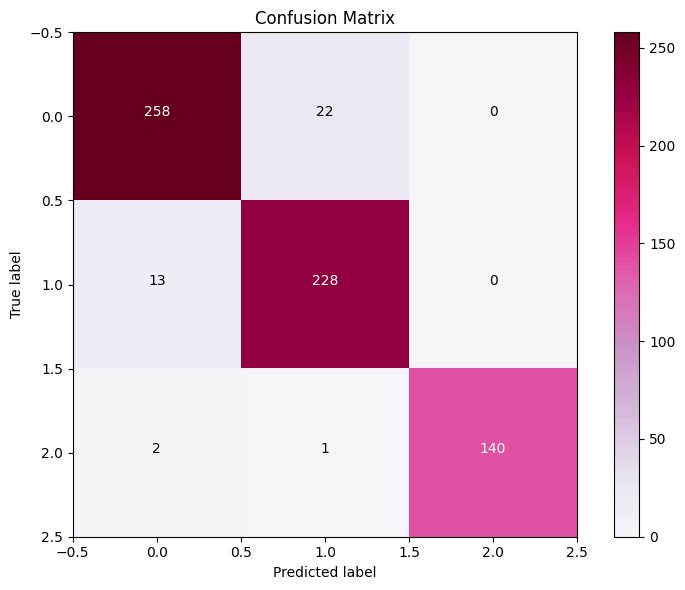

In [18]:
############# plot confusion matrix ############

from matplotlib import pyplot as plt
from sklearn import metrics

cm = metrics.confusion_matrix(y_test, test_preds_SVC.round())
# Plot confusion matrix with custom color map

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.PuRd)  # Set cmap to custom color map
plt.title('Confusion Matrix')
plt.colorbar()

# Adding annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), #'d = integer
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout() #improves the layout of plots by preventing overlapping elements such as axis labels, tick labels, and titles
plt.show()


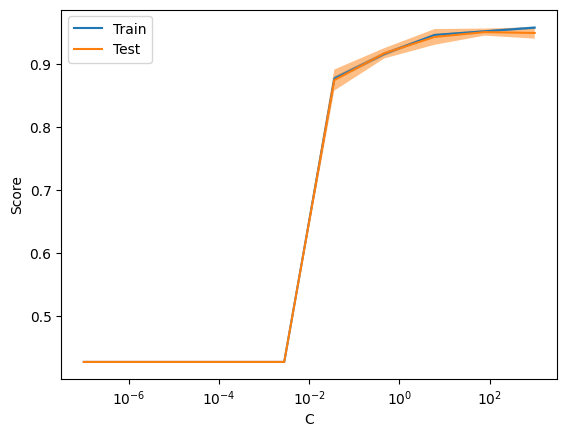

In [19]:
############# validaition_curve #####################
from sklearn.model_selection import ValidationCurveDisplay
ValidationCurveDisplay.from_estimator(
   SVC(**trial.params), compressed_dataset_X, label, param_name="C", param_range=np.logspace(-7, 3, 10)
)
plt.show()